Here, we present a collection of Sage functions for working with partial orders and linear forms in the context of genetic interaction studies. These are intended as a companion to the paper *Inferring genetic interactions from partial fitness orders* (Caitlin Lienkaemper, James Drain, Lisa Lamberti, Alex Gavryushkin, 2017, to appear). 

A public Sage worksheet containing everything can be found at https://cocalc.com/projects/c67c7038-6d14-4820-8f06-ba84fd2ff8e8/files/epistasis_and_posets_public.sagews. 

## Creating Posets 

For a thourough treatment how how Sage handles finite posets, see 
http://doc.sagemath.org/html/en/reference/combinat/sage/combinat/posets/posets.html. 
Sage can construct posets from (acyclic) directed graphs. For instance:


In [1]:

posetwithepi=Poset(DiGraph([[0,1,10,11],[(10,0),(1,0),(1,11),(10,11)]],format='vertices_and_edges'))



Further, we can visualize the Hasse diagrams of posets nicely. 

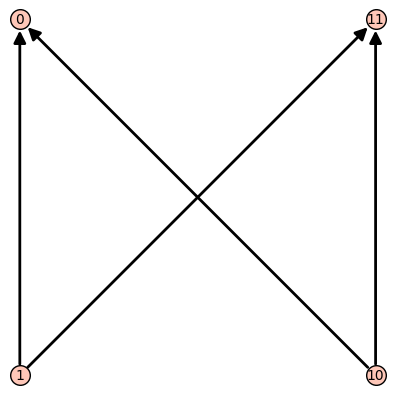

In [10]:
posetwithepi.show()

In addition to the build in functionality Sage has for posets, we have added a few poset functions which we found to be helpful. 

In [15]:
#imput: two partial orders
#output: the intersection of the partial orders--that is, the partial order p in which x<y if and only if x<y in p1 and p2
def poset_intersection(poset1, poset2):
    #if poset1.list() != poset2.list():
       # return "error, posets are not on the same set of elements"
    elements = poset1.list()
    list_of_edges = []
    for x in elements:
        for y in elements:
            if poset1.is_less_than(x,y) and poset2.is_less_than(x,y):
                list_of_edges.append((x,y))
    return Poset(DiGraph([elements,list_of_edges], format = 'vertices_and_edges'))

def intersection_gives_digraph(poset1, poset2):
    elements = poset1.list()
    list_of_edges = []
    for x in elements:
        for y in elements:
            if poset1.is_less_than(x,y) and poset2.is_less_than(x,y):
                list_of_edges.append((x,y))
    return DiGraph([elements,list_of_edges], format = 'vertices_and_edges')
    

#checks if two total orders differ by one transposition or less 
def check_adjacency(list1, list2):
    numswaps = 0
    i=0
    while i<(len(list1)-1):
        if list1[i] == list2[i]:
            i = i + 1
        if list1[i] != list2[i]:
            if numswaps == 0 and list1[i]==list2[i+1]:
                if list1[i+1]==list2[i]:
                    numswaps = numswaps+1
                    i = i + 2
                else: return false
            else: return false
    return true


#makes a list of list into a list of strings
def to_string(list_of_lists):
    strings = []
    for list in list_of_lists:
        strings.append(str(list))
    return strings

#input: a poset
#output: a graph whose vertices are the linear extensions of the poset. there is an edge on a pair of vertices if they are connected by a single adjacent transposition
def linear_extensions_graph(poset):
    extensions = poset.linear_extensions().list()
    vertices = to_string(extensions)
    edges = []
    for ext1 in extensions:
        for ext2 in extensions:
            if check_adjacency(ext1, ext2):
                edges.append((str(ext1),str(ext2)))
    return Graph([vertices, edges])

#input: a list
#output: a finite poset which is the rank order from this list
def rank_order_from_list(list):
    vertices = list
    edges = []
    for i in range (len(list)-1):
        edges.append((list[i], list[i+1]))
    return Poset(DiGraph([vertices, edges]))

For instance, we can now create posets from rank orders very easily, and construct more complicated posets by intersecting these linear orders. For instance, consider the rank orders 

\begin{align*}
r_1: \,w_{111} > w_{011} > w_{001} > w_{101} > w_{010} > w_{100} > w_{110} > w_{000}\\
r_2: \, w_{111} > w_{011} > w_{001} > w_{010} > w_{100} > w_{101} > w_{110} > w_{000}\\
r_3: \, w_{111} > w_{011} > w_{010} > w_{001} > w_{100} > w_{110} > w_{101} > w_{000}\\
\end{align*}

obtained by measuring growth rates of the parasite *Plasmodium vivax* under the three highest concentrations tested of the antimalarial drug pyrimethamine. We can create a poset for each order using rank_order_from_list().



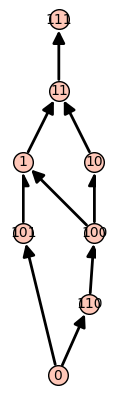

In [12]:
r1= [0,110,100,10,101, 1,11,111]
r2= [0,110,101,100,10,1,11,111]
r3= [0,101,110,100,1,10,11,111]
order1 = rank_order_from_list(r1)
order2 = rank_order_from_list(r2)
order3 = rank_order_from_list(r3)
intersection = poset_intersection(poset_intersection(order1, order2), order3)
intersection.show()

We can find all linear extensions of this poset and draw the linear extensions graph (the graph with linear extensions as vertices and edges between linear extensions which differ by one adjacent transposition). 

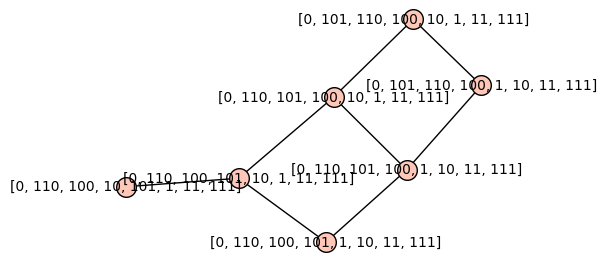

In [16]:
linear_extensions_graph(intersection).show()

In [24]:
#Our efficient implementation for checking whether a partial order implies epistasis, and its helper functions
#input: a directed graph, two labels, and a partition
#output: a bipartite graph whose verties are the elments of the original directed graph. the partition in the graph is between vertices labeled with letter 1 and letter 2. there is an edge between vertex u labeled with letter1 and vertex v labeled with letter2 if there is a directed path from u to v
def one_sided_comparability_bigraph(digraph, letter1, letter2, partition):
    adjacency = {}
    for vertex in digraph.vertices():
        adjacency[vertex]=[]
        if partition[vertex] == letter1:
            reachable = list(digraph.breadth_first_search(vertex))
            neighbors = []
            for neighbor in reachable:
                if partition[neighbor]==letter2:
                    neighbors.append(neighbor)
            adjacency[vertex]=neighbors
    return Graph(adjacency)

#input: a graph, a partition, and the partition labels
#output: true if the graph has a perfect matching and false otherwise
def check_matching(graph, partition, letter1, letter2):
    copy = Graph(graph)
    size = len(graph.vertices())/2
    for vertex in copy.vertices():
        if partition[vertex]==letter1:
            copy.add_edge('s', vertex)
        if partition[vertex]==letter2:
            copy.add_edge('t', vertex)
    max_flow = int(copy.flow('s','t'))
    if size == max_flow:
        return true

#input: a directed graph, a partition on the vertices, and the labels used in the partition
#output: "positive epistasis implied", "negative epistasis implied", "no epistasis implied" 
def quick_epistasis_check(digraph, partition, letter1, letter2):
    bigraph1 = one_sided_comparability_bigraph(digraph, letter1, letter2, partition)
    if check_matching(bigraph1, partition, letter1, letter2):
        return -1
    bigraph2 = one_sided_comparability_bigraph(digraph, letter2, letter1, partition)
    if check_matching(bigraph2, partition, letter1, letter2):
        return 1
    else:
        return 0
    

For instance, we can check whether the partial order we got by intersecting the three rank orders coming from our *plasmodium vivax* example implies interaction. First, we need to define a partition based off of our linear form, 

$$f(\bar w) = w_{000} + w_{011} + w_{101} + w_{110} - w_{001} - w_{010} - w_{100} - w_{111}.$$

That is, we want to assign the elements with positive coefficients to one class and the elements with negative coefficients to the other. 



In [21]:
partition3={0: "P", 1: "N", 10:"N", 11:"P", 100:"N", 101:"P", 110:"P", 111:"N"}


Now, we run quick_epistasis_check() and get an answer. 

In [25]:
quick_epistasis_check(intersection.hasse_diagram(), partition3, "P", "N")

-1

Since the function returns -1, we see that this partial order implies negative $f$-interaction. That is, for any choice of $\bar w$ compatible with this partial order, $f(\bar w)<0$. 

# Counting partial orders which imply interaction

Using this work we are able to count partial orders on 2, 4, 6, and 8 elements which imply interaction. 

In [26]:
# Our function for computing the proportion of partial orders on n elements which imply epistasis 
# would not reccomend using with n>8
# or n odd

#input: an even number n 
#output: a list containing each dictionary on the elements 0, ..., n-1 such that n/2 of the keys have the value 1 and the other n/2 have the value 0
def bipartitions(n):
    partitions_n = []
    for subset in Subsets(n, n/2):
        partition = {}
        for x in range (0, n):
            if x+1 in subset:
                partition[x]=1
            else: partition[x]=0
        partitions_n.append(partition)
    return partitions_n

#input: an even number. quick for n = 2, 4, 6, takes ~2 hours for n=8; with good luck, might finish n=10 this century
#output: a tuple containining the number of posets 
def prop_implying_epistasis(n):
    count_pos = 0
    count_neg = 0
    count_none = 0
    posets_n = Posets(n)
    offset = factorial(n/2)^2
    for poset in posets_n:
        hasse = poset.hasse_diagram()
        auto = hasse.automorphism_group().cardinality()
        for bipartition in bipartitions(n):
            if quick_epistasis_check(hasse, bipartition, 0, 1)==1:
                count_pos = count_pos + 1/auto
            elif quick_epistasis_check(hasse, bipartition, 0, 1)==-1:
                count_neg = count_neg+1/auto
            else: count_none = count_none+1/auto
    return (count_pos*offset, count_neg*offset, count_none*offset)

For instance, we can find the number of partial orders on 4 elements implying $f$-interaction very quickly: 

In [27]:
prop_implying_epistasis(4)

(31, 31, 157)

This output means that on 4 elments, there are 31 posets that imply positive interaction, 31 posets that imply negative interaction, and 157 posets that do not imply interaction. 